# Reddit Art Classifier

This project is designed to create a CNN classifier using images pulled from [r/Art](reddit.com/r/Art) on Reddit.

Image classification is a widely used process and a significant ammount of research and applied technologies have indicated that convolutional neural networks are one of the most optimal algorithms for image recognition. Convolutional neural networks have proven to be highly capable and extremely accurate at recognizing objects within images as well as identifying diseases and tumors in tissue and brain scans. This project will be something simmilar to the latter of the two in that the objects in the image are irrelevant, instead I'm trying to get my model to pick up on the small details in the image that would indicate the difference between a real brushstroke and a digital brushstroke.



This project was built primarily as a way for me to practice building large datasets by writting code to automate the process of pulling data from a website, attaching labels to the data, and then sorting and storing the data. The process I used to develope my dataset is probably the most generalizable work contained in this project, though I can see some potential applications for the model itself given time to train it on a large enough dataset. I think a potentially more useful approach, specifically in terms of applications aimed at improving the user experience on reddit, would be to build a classifier that pulls images from a multitude of different subreddits that could then be used to classify new images by which subreddit they should be posted to (for example an art piece would be classified as r/Art while a meme might get classified as r/memes). This type of classification would require a slightly different model architecture but the overall process developed in this project would lend itself nicely to this extrapolation.

First I'll need to import all of this project's dependencies as well as creating paths to the relevant source code and data directories within the repository

In [1]:
# creating paths to src and data folders in the repo
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

# source code functions for this project
import data_setup as ds
import modeling_functions as mf

# basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import random

# import modeling packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# modeling metrics
from sklearn.metrics import classification_report, confusion_matrix

## Creating the API Object and Retrieving Submissions

Now I'll need to create an instance of the pushshift psaw api. This api will allow me to search through all of reddit's content to retrieve the submissions required to build my dataset. If you want to use the get_api_instance() function you will have to create an api_credentials.txt file in the src folder that contains your own api credentials in the format

client_id=myid  
client_secret=mysecret  
agent=myagent

for more information on how to obtain api credentials visit [this](https://praw.readthedocs.io/en/latest/getting_started/quick_start.html) reference page

In [2]:
reddit = ds.get_api_instance(src_path)

Next I'll use this api to pull data from as many posts as I'd like. For this project I used a dataset of 6400 images, 3200 that were made using digital means, and 3200 made using other means. Only about one third of posts made to r/Art are created using digital means, so my function fetch_balanced_submissions ensures that an equal number of posts is collected from each category to produce a balanced dataset.

In [ ]:
table_of_contents = [ds.make_post_dict(post) for post in ds.fetch_balanced_submissions(6400, reddit, binary=True)]

Since the process of finding and downloading the submissions as well as downloading the associated images takes so long to complete, I'm writting the most critical meta-data to a json file so that it won't be lost when restarting the kernel

In [4]:
writeable_toc = [ds.make_post_dict_no_obj(post['post']) for post in table_of_contents]
toc_path = data_path / 'meta_data.json'
with open(toc_path, 'x') as f:
    f.write(json.dumps(writeable_toc))

In [3]:
# run this to load the json file into memory
# change 'meta_data.json' to 'meta_data_final.json' if you want to use the original data that I used

# toc_path = data_path / 'meta_data_final.json'
# json_string = open(str(toc_path)).read()
# table_of_contents = json.loads(json_string)

I'm taking a look at the distribution of medium types. Although it's only a binary classifiation there are still a total of 5 different medium classes (digital and non-digital which contains 4 classes: ink, non-ink-drawing, paint, sculpture)

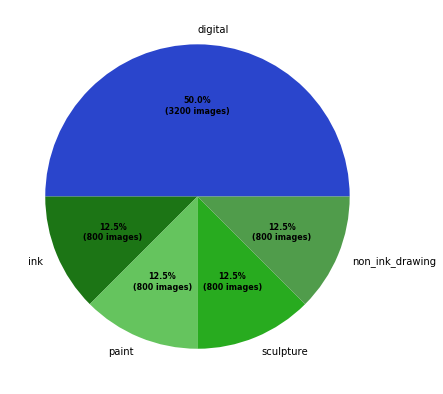

In [39]:
toc_df = pd.DataFrame(table_of_contents)

fig_path = pathlib.Path().absolute().parent.parent / "reports/figures/charts"

colors = ("#2A45CC", "#1C7515","#65C45E",
          "#28AB1F", "#509C4B", "#2DC223") 

def get_percentages(pct, allvalues): 
    absolute = int(pct / 100.*sum(allvalues)) 
    return "{:.1f}%\n({:d} images)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(toc_df.medium.value_counts().values,  
                                  autopct = lambda pct: get_percentages(pct, list(toc_df.medium.value_counts().values)), 
                                  labels = toc_df.medium.value_counts().index,
                                  colors = colors,
                                  textprops = dict(color='black'),
                                  startangle = 0)
  
plt.setp(autotexts, size = 8, weight ="bold")
  
pie_path = fig_path / 'pie_distribution_final_black.png'
plt.savefig(pie_path, transparent=True)
plt.show()

## Downloading the Data

For this project I used the flow-from-directory process to sequentially load batches of images to train on. This requires a specificlly formatted directory structure. establish_binary_directory() creates the file structure required for flow-from-directory process within the specified file path.

Once the file structure is established, I can begin downloading the images for each post and storing them in their propper folders using download_and_store_binary. I used 3000 images per category for training, 100 per category for testing, and 100 per category for validation.

In [5]:
# create a directory structure to store sorted images with a train/test/validation split
ds.establish_binary_directory(data_path)

# download, sort, split, and store images from each post into the new file structure
# the filename for each image will be set using the format 'postid.(jpg|png)'
binary_data_path = data_path / 'binary_tts'
ds.download_and_store_binary(table_of_contents, binary_data_path, [3000, 100, 100])

## Building and Training the Model

Since I'm using the flow-from-directory process, before I can start modeling I need to create ImageDataGenerator objects using their flow_from_directory() method. make_image_generators() initializes these objects for each split with the proper parameters.

In [6]:
train_generator, test_generator, val_generator = mf.make_image_generators(binary_data_path)

Found 6000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Next I'll compile a keras CNN model using my make_model() function. make_model() returns a compiled keras model with the arcitecture that gave me the best results during testing.

In [10]:
model = mf.make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 298, 298, 35)      980       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 35)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 57, 20)        6320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7220)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                288840    
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)               

Finally I can train the model using the data generators I just created. I got my best results after about 4 epochs of training, so I'll use 4 epochs again here. Beyond 4 epochs i could occasionally get higher accuracy on the validation data but the loss would also typically begin to increase, indicating in increase in the model's uncertainty and therfore the increase in accuracy beyond 4 epochs is likely due to 'lucky guesses' and is not a good indicator that the model is continuing to improve.

In [11]:
model.fit(train_generator,
          steps_per_epoch=300,
          epochs=4,
          validation_data=val_generator,
          validation_steps=10)

Epoch 1/4
288/300 [===========================>..] - ETA: 44s - loss: 0.6639 - accuracy: 0.6132

/opt/anaconda3/envs/new_capstone-env/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


300/300 [==============================] - 1157s 4s/step - loss: 0.6634 - accuracy: 0.6132 - val_loss: 0.6473 - val_accuracy: 0.6000
Epoch 2/4
300/300 [==============================] - 1136s 4s/step - loss: 0.6380 - accuracy: 0.6383 - val_loss: 0.6466 - val_accuracy: 0.6300
Epoch 3/4
300/300 [==============================] - 1124s 4s/step - loss: 0.6369 - accuracy: 0.6483 - val_loss: 0.6316 - val_accuracy: 0.6450
Epoch 4/4
300/300 [==============================] - 1122s 4s/step - loss: 0.6231 - accuracy: 0.6672 - val_loss: 0.6550 - val_accuracy: 0.6400


## Model Evaluation

First I'll analyze the confusion matrix for the validation data I used during model developement

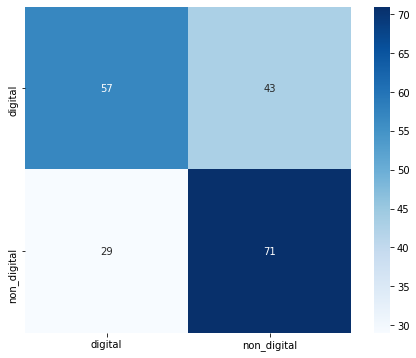

In [12]:
# validation matrix
predictions = model.predict_classes(val_generator)

conf_mat = confusion_matrix(val_generator.classes, predictions)

class_names = list(val_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
final_model_validation_path = pathlib.Path().absolute().parent.parent / 'reports/figures/charts/final_validation_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(final_model_validation_path)

lets take a look at what types of images are being miss-classified

In [13]:
val_files = val_generator.filenames
actual = val_generator.classes
val_path = data_path / 'binary_tts/val'
incorrect = []
for i in range(0, len(actual)):
    if predictions[i][0] != actual[i]:
        incorrect.append((val_files[i], actual[i]))

digital/jn7nyq.png
title: Just the Tip, Me, Digital, 2020
medium: digital


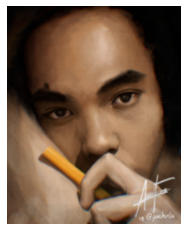

In [27]:
item = random.choice(incorrect)
print(item[0])
# this line grabs the post id number out of the file name collected from ImageDataCollector
post = ds.find_submission_dict_by_id(item[0].split('/')[1].split('.')[0], table_of_contents)
print(f"title: {post['title']}\nmedium: {post['medium']}")
file_path = val_path / item[0]
img = mpimg.imread(str(file_path))
plt.axis('off')
display = plt.imshow(img, interpolation='bicubic')

digital/jn8b8n.jpg
title: Operation Juno's Rosehip, me, digital, 2020
medium: digital


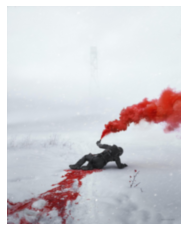

In [24]:
item = random.choice(incorrect)
print(item[0])
# this line grabs the post id number out of the file name collected from ImageDataCollector
post = ds.find_submission_dict_by_id(item[0].split('/')[1].split('.')[0], table_of_contents)
print(f"title: {post['title']}\nmedium: {post['medium']}")
file_path = val_path / item[0]
img = mpimg.imread(str(file_path))
plt.axis('off')
display = plt.imshow(img, interpolation='bicubic')

non_digital/gja6kv.jpg
title: Flip flop love, Alicia LaRue, wool wire armature driftwood base,2020
medium: sculpture


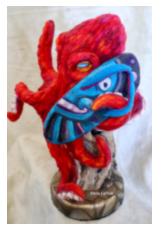

In [16]:
item = random.choice(incorrect)
print(item[0])
# this line grabs the post id number out of the file name collected from ImageDataCollector
post = ds.find_submission_dict_by_id(item[0].split('/')[1].split('.')[0], table_of_contents)
print(f"title: {post['title']}\nmedium: {post['medium']}")
file_path = val_path / item[0]
img = mpimg.imread(str(file_path))
plt.axis('off')
display = plt.imshow(img, interpolation='bicubic')

It looks like the images that my model is struggling with the most are digital images that are created in a way that mimics traditional mediums. Additionally it has difficulty with black and white images, my guess is because they resemble pen drawings. One good thing to note from this though is that it does appear my model is picking up on the details within the stroke of the artwork instead of basing the predictions on objects and larger composistion which is what I was going for when designing the model architecture.

Next I'll check to see if the final testing data follows the same trend

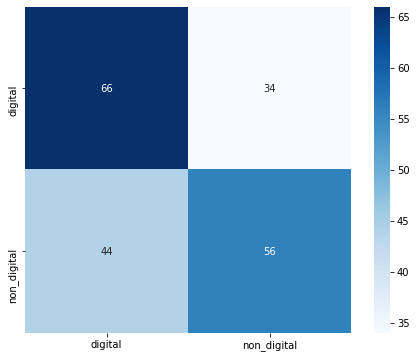

In [28]:
# testing matrix
conf_mat = confusion_matrix(test_generator.classes, model.predict_classes(test_generator))

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
final_model_test_path = pathlib.Path().absolute().parent.parent / 'reports/figures/charts/final_test_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(final_model_test_path)

It looks like my model has similar performance on data that was completely unseen and unused during the development process, so at least it's consistent in its predictions.

## Potential Improvements

I could potentially improve on this model a few different ways. The first could be as simple as increasing the size of the dataset. Due to time constraints and the ammount of time it took to download all of the images necessary to create the dataset as well as the time it takes to train on larger datasets, I capped my training data at 6000 images. My code searches for posts in chronological order and the 6400 it collected (the additional 400 being the testing and validation sets) only dated back about a month at the oldest. Considering the subreddit was established in 2008, there are plenty more images available for me to concatonate to my dataset. Another potential solution would be to create an ensemble of CNN models that pick up on different features within the images. this could potentially increase accuracy on images that my current model is less certain about.